In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval
from scipy.ndimage import gaussian_filter
from astropy.stats import mad_std
from astropy.stats import sigma_clipped_stats
# from photutils.aperture import CircularAperture
# from photutils.aperture import SkyCircularAperture
# from photutils.aperture import aperture_photometry
# import os
from astropy.table import Table
import matplotlib.ticker as ticker
from make_cuts import choosef, random_apers, get_names, radec_minmax, cuts

#from astroML.plotting import MultiAxes
from scipy.optimize import curve_fit

In [2]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [7]:
df = Table.read('NSF_fake_sources_13.fits') #FUENTES FALSAS
data = Table.read('NSF_merged_sims_13.fits') #cATÁLOGO DPS DE SEXTRACTOR

In [40]:
df

mag_nb_arr,mag_bb_arry,f_bb_arrz,ra_arr,f_bb_arry,x_arr,dec_arr,x2_arr,logl_arr,wave_arr,f_nb_arr,ew0_arr,y_arr,y2_arr,mag_bb_arrz
float64,float64,float64,float64,float64,float32,float64,float32,float64,float64,float64,float64,float32,float32,float64
25.35642575697753,25.858034560505487,0.7975647236163299,315.8090966345575,2.8627681434984615,22281.0,-66.95522586990272,22281.0,42.67694995396472,9588.638921004542,4.54390975281281,22.90202477519904,3407.0,3407.0,27.245585157921965
24.93800488688592,26.362045609265337,0.5479298000330393,319.3688597570393,1.799623916953448,3243.0,-66.04120966178229,3243.0,42.763011438976115,9636.776794190195,6.680331978628932,57.68559548700466,15416.0,15416.0,27.653187697818282
24.86170493272867,26.00176489694354,0.7598009070443171,317.1223081230283,2.50780660120579,15416.0,-66.51701304910245,15416.0,42.88125130840833,9594.465715847213,7.166680226465457,53.682600646759596,9311.0,9311.0,27.298250480809173
25.001555189913645,26.244937364985375,0.5854104977075758,318.22933451209843,2.0045876666481632,9311.0,-65.6536163690722,9311.0,42.72002122816206,9636.027595875608,6.300542189693333,40.8610364789617,20759.0,20759.0,27.581348734924703
25.33319553738835,26.342907055690787,0.5167199667978702,316.13649057177906,1.8316275941966726,20759.0,-65.95214674801448,20759.0,42.60986000445857,9653.192116332877,4.642177957108256,31.37254593639161,16810.0,16810.0,27.71686189092685
24.248665620673478,25.289724210962802,1.3601135799621904,316.2063665517125,4.831815199179706,20519.0,-65.13759366724805,20519.0,43.024148500474844,9645.247758213252,12.604735933459226,30.754859659882055,27676.0,27676.0,26.666062057950967
24.74981142726847,26.434715229917146,0.5516499815228366,314.8837918326131,1.68311545565133,27594.0,-65.88604234104832,27594.0,42.844702522952815,9612.332905315767,7.944662071459798,103.29363896276446,17528.0,17528.0,27.645840980079385
25.687200175029176,26.315822872285153,0.5255479351579893,316.72512467524916,1.8778930346291505,17528.0,-66.48956464564722,17528.0,42.627387059500066,9678.806256891883,3.350579523031199,30.960996636294976,9674.0,9674.0,27.6984691647165
28.557716628293534,24.77049176467682,1.937639920232929,318.2235701783435,7.794769804852243,9674.0,-66.9403205863667,9674.0,43.01635019409471,9708.173146936118,0.23818441915536248,14.13936512902572,3605.0,3605.0,26.28181731638834


In [20]:
def func(x,a):
    return a

In [21]:
aper = 1
BB = np.array([data['MAG_APER_z'][i][aper] for i in range(len(data))])


NB = np.array([data['MAG_APER'][i][aper] for i in range(len(data))])

In [27]:
mask_cont = (NB >= 19) & (NB <= 21) & (
    BB-NB > 0) & (BB-NB < 0.5)
cont_dfs = data[mask_cont]

magNB_cont = np.array([cont_dfs['MAG_APER'][i][aper] for i in range(len(cont_dfs))])

magBB_cont = np.array([cont_dfs['MAG_APER_z'][i][aper] for i in range(len(cont_dfs))])

diff_cont = magBB_cont-magNB_cont

ew_end = 0.44

NB_5s = 24.98

popt_new, pcov = curve_fit(func, NB, diff_cont)
print(popt_new)

data['MAG_APER'] = data['MAG_APER'] + popt_new
#NB_corr = (NB+popt_new)
NB_corr = np.array([data['MAG_APER'][i][aper] for i in range(len(data))])

[0.4110906]


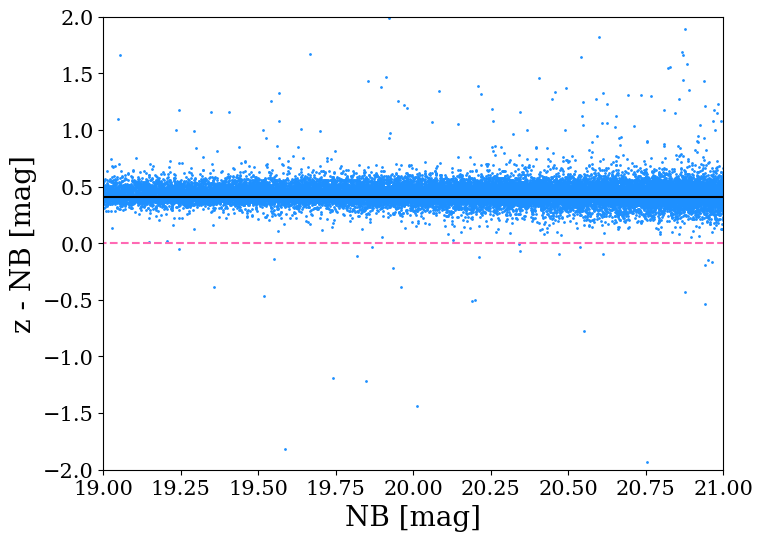

In [28]:
fig, ax= plt.subplots(figsize=(8,6),facecolor= 'w', dpi=100)

ax.scatter(NB,BB-NB,c = 'dodgerblue', s=1)
#ax.plot(mags[:-numb], sigma_c, color = 'crimson')
#ax.plot(fp, a)

ax.set_xlim(19,21)
ax.set_ylim(-2,2)
ax.set_xlabel('NB [mag]')
ax.set_ylabel('z - NB [mag]')
ax.hlines(0,14,28, linestyle = 'dashed', color ='hotpink')
ax.hlines(popt_new,14,28)

plt.show()

In [32]:
%%time

sig_clip = []
numbers = np.arange(np.min(NB_corr), np.max(NB_corr), 0.125)
# print(numbers)
for i, n in enumerate(numbers):
    # print(n)
    mask = (NB_corr >= n) & (NB_corr < n+0.125)
    BB_a = BB[mask]
    NB_a = NB_corr[mask]
    sig_c = sigma_clipped_stats((BB_a - NB_a), sigma=5, cenfunc='median')
    sig_clip.append(3*sig_c[2])
    # print(3*sig_c[2])

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


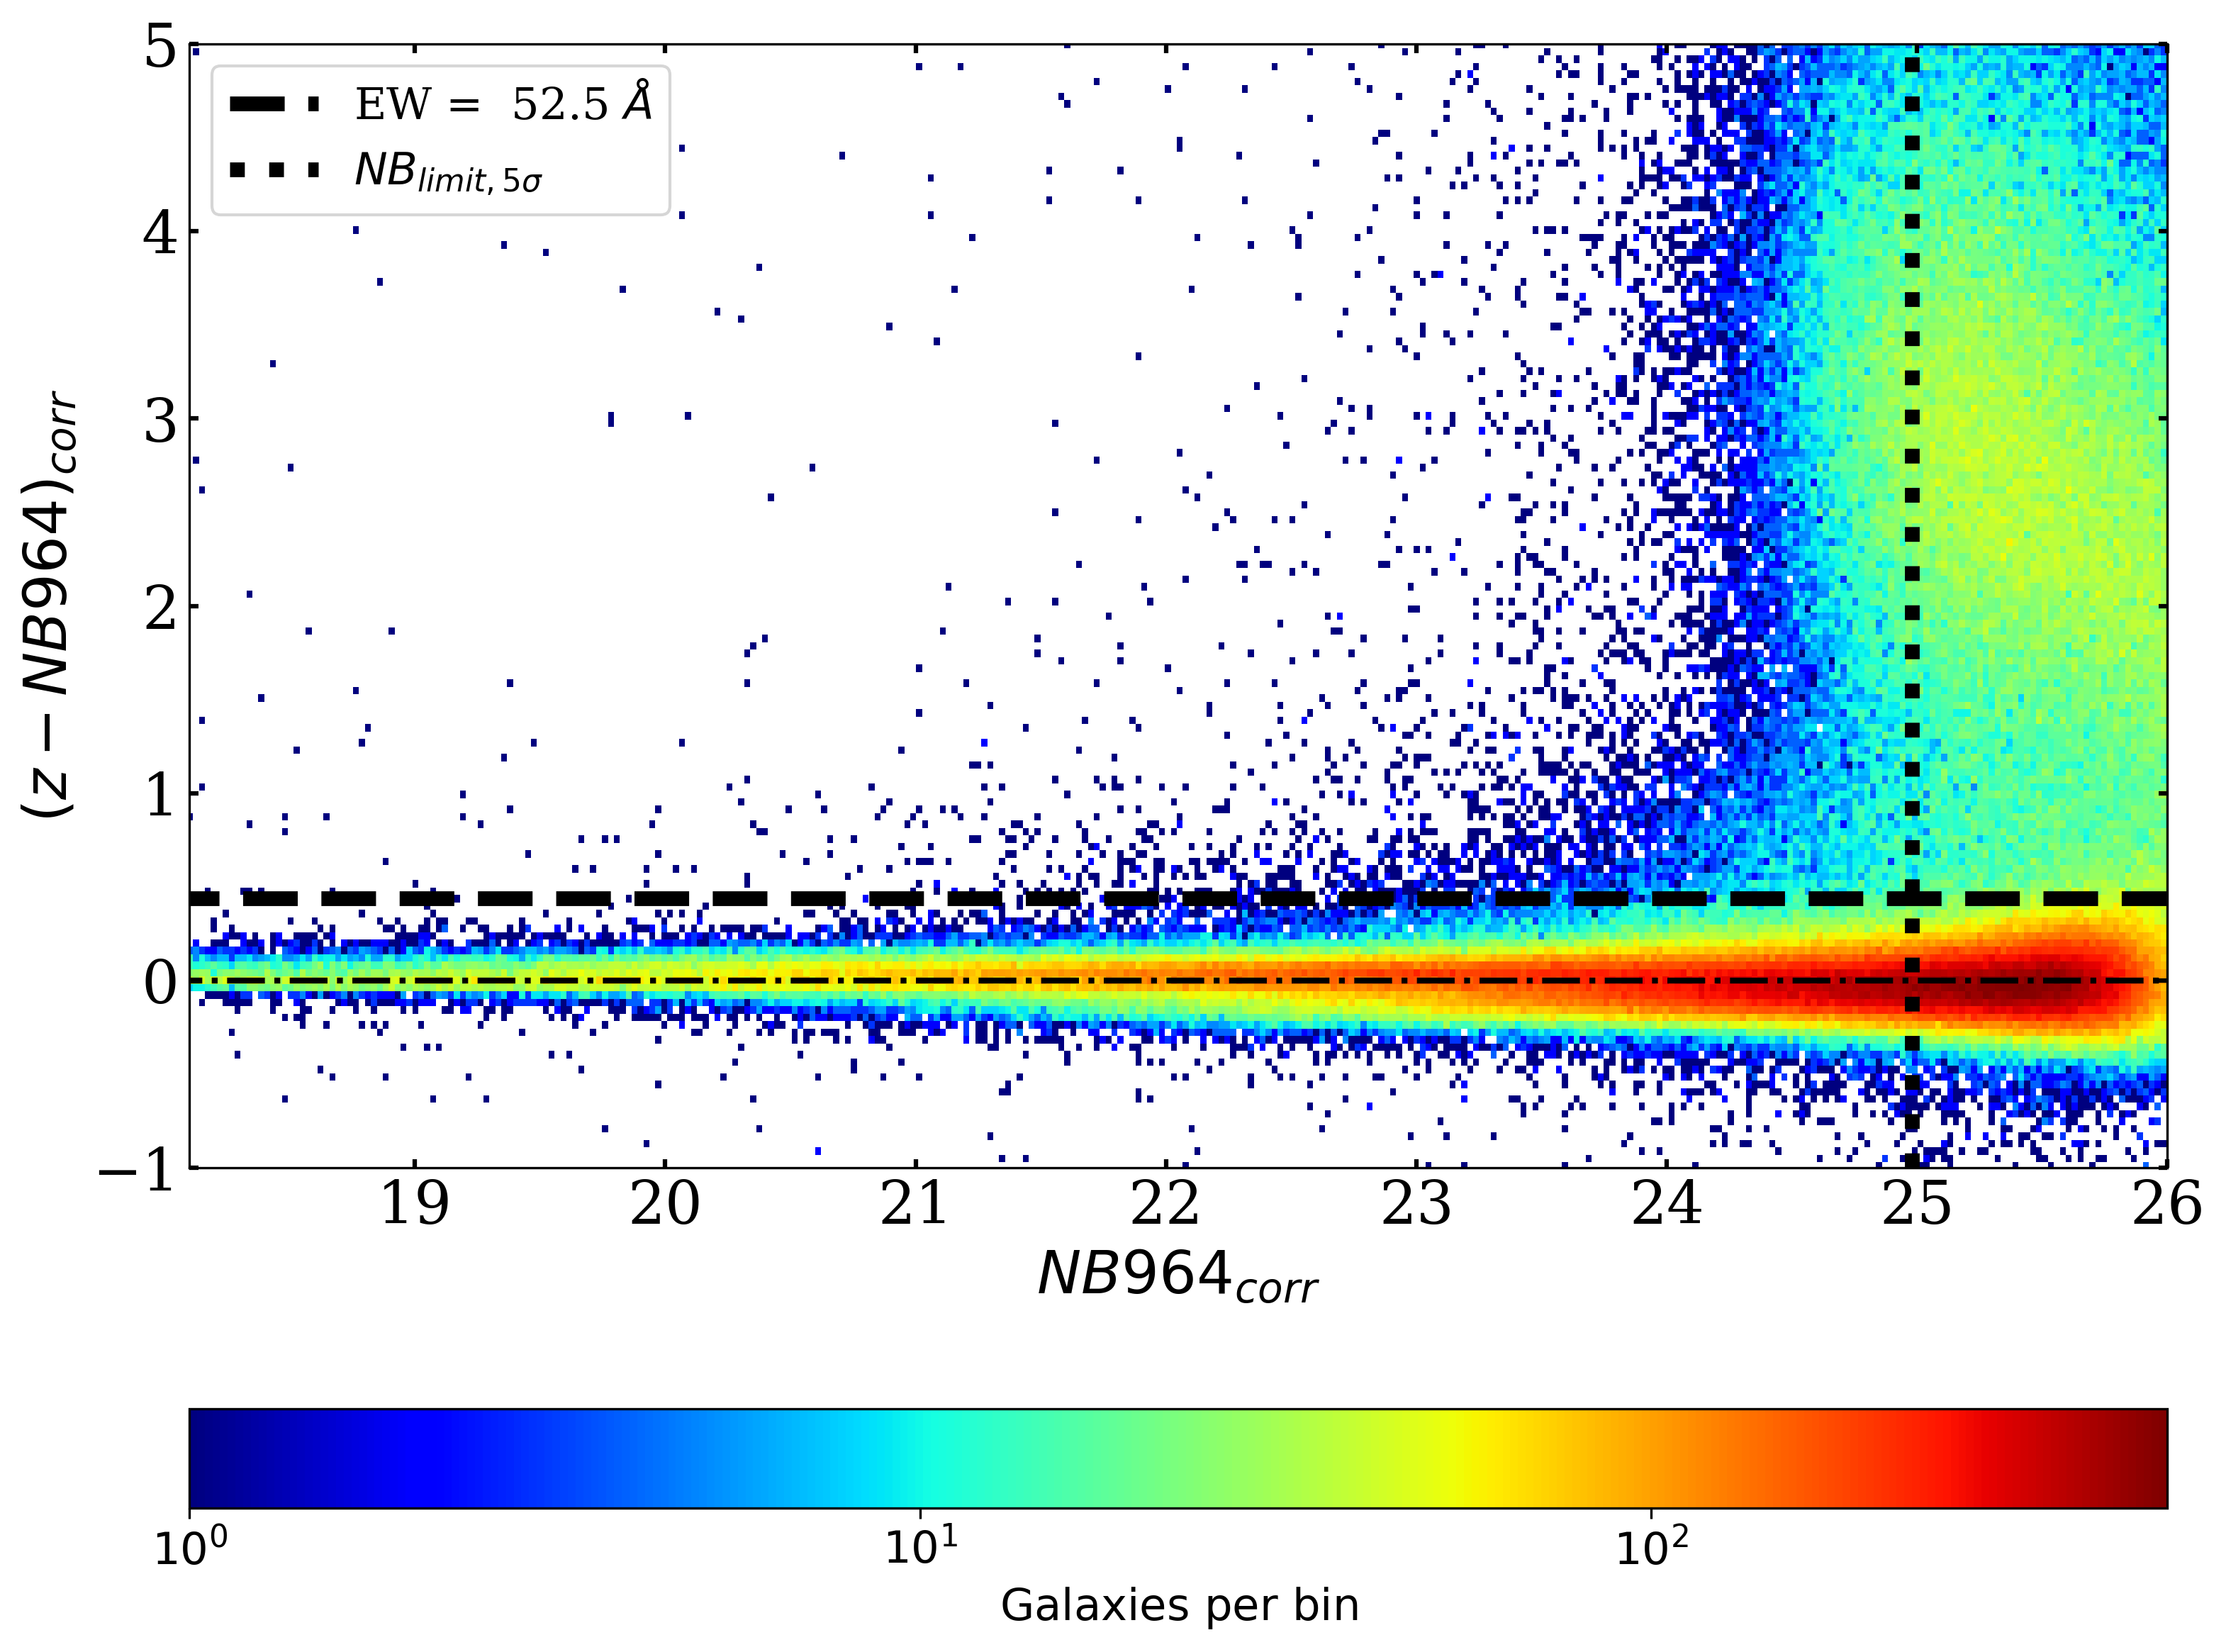

In [36]:
from astroML.stats import binned_statistic_2d

mask_value =  ((BB -NB_corr)  > -25 ) & ((BB -NB_corr)  < 25 ) & (NB_corr < 30)
N, xedges, yedges = binned_statistic_2d(NB_corr[mask_value], (BB[mask_value]-NB_corr[mask_value]), NB_corr[mask_value],
                                        'count', bins=700)

cmap = plt.cm.jet
cmap.set_bad('w', 1.)

cmap_multicolor = plt.cm.jet
cmap_multicolor.set_bad('w', 1.)

fig = plt.figure(figsize=(12, 10), dpi = 300)
#--------------------
# First axes:
plt.imshow(np.log10(N.T), origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='jet')


cb = plt.colorbar(ticks=[0, 1, 2, 3],
                  format=r'$10^{%i}$', orientation='horizontal')
cb.set_label(r'$\mathrm{Galaxies\ per\ bin}$', size = 15)


#ax.hlines(0,18,27, linestyle='dotted', color ='hotpink')
plt.hlines(ew_end,18,27, linestyle='dashed', color ='k', linewidth = 5, label = r'EW =  52.5 $\AA$')
plt.hlines(0,18,27, linestyle='-.', color ='k', linewidth = 2)
plt.vlines(NB_5s,-1,5, linestyle='dotted', color ='k', linewidth = 5, label = r'$NB_{limit,5\sigma}$')
#plt.plot(numbers,sig_clip, color = 'k', linewidth = 5, label = '3$\sigma$')

plt.ylabel(r'$(z - NB964)_{corr}$')
plt.xlabel(r'$NB964_{corr}$')

#plt.major_locator(ticker.MultipleLocator(1))      # Ticks principales cada 1 unidades en el eje x
#plt.minor_locator(ticker.MultipleLocator(0.5))    # Ticks secundarios cada 0.1 unidades en el eje x
#plt.major_locator(ticker.MultipleLocator(0.25))      # Ticks principales cada 1 unidades en el eje y
#plt.minor_locator(ticker.MultipleLocator(0.05))    # Ticks secundarios cada 0.5 unidades en el eje y
plt.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
plt.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
plt.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
plt.tick_params(axis='y', which='minor', bottom=True, top=True, direction='in', length=3)



plt.tick_params(direction = 'in', length = 3, width = 1.5, colors = 'k', labelsize = 20)
plt.legend(loc = 2)
plt.xlim(18.1,26) 
plt.ylim(-1,5)
plt.show()

In [37]:
mask= (NB_corr < NB_5s) & ((BB-NB_corr) > ew_end)
#mask2 = ((BB-NB_corr) > ew_end)
data_elg = data[mask]

In [38]:
data_elg

NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER [2],FLUXERR_APER [2],MAG_APER [2],MAGERR_APER [2],FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,BACKGROUND,ALPHAPEAK_J2000,DELTAPEAK_J2000,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,MAG_APER_g [2],MAG_APER_r [2],MAG_APER_i [2],MAG_APER_z [2],MAG_APER_y [2],MAGERR_APER_g [2],MAGERR_APER_r [2],MAGERR_APER_i [2],MAGERR_APER_z [2],MAGERR_APER_y [2],FLUX_APER_g [2],FLUX_APER_r [2],FLUX_APER_i [2],FLUX_APER_z [2],FLUX_APER_y [2],FLUXERR_APER_g [2],FLUXERR_APER_r [2],FLUXERR_APER_i [2],FLUXERR_APER_z [2],FLUXERR_APER_y [2]
int32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
8,7.425536,0.08673328,24.823181,0.012684922,9.385968 .. 10.62757,0.08659234 .. 0.09884657,24.979892484836757 .. 24.845004789524257,0.010019135 .. 0.010100839,9.553036,0.123447224,24.549646,0.014033621,-0.24408248,318.1155491905241,-67.127221341231,10282.993,1124.1686,318.115549971541,-67.12720869370712,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
27,11.250538,0.10710818,24.372066,0.010339016,7.8799853 .. 11.082924,0.085120164 .. 0.10044554,25.169776670627773 .. 24.79945539682406,0.01173105 .. 0.009842516,17.772139,0.1607771,23.87565,0.009824588,-0.6378866,318.0868031907672,-67.12726699595842,10431.666,1125.8807,318.08686797739404,-67.12727550065641,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
42,12.320069,0.12347599,24.273468,0.010884267,7.5951347 .. 10.284006,0.08147438 .. 0.09464222,25.20975279062289 .. 24.88068556039828,0.011649718 .. 0.009994301,10.184998,0.19201097,24.480097,0.020473635,-0.00080798287,318.0162035270376,-67.12765051665382,10797.694,1127.3895,318.0162612330052,-67.12762094427114,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
43,15.1403885,0.12745674,24.049658,0.009142303,7.0269866 .. 9.837154,0.082631886 .. 0.096124396,25.294168226413905 .. 24.92891668527621,0.012770514 .. 0.010611919,19.508255,0.2003884,23.774454,0.01115537,-0.17139694,317.9421233644943,-67.12787317365134,11183.621,1130.137,317.94181017765754,-67.12786471929265,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
56,12.414932,0.12506384,24.265139,0.010939998,7.871891 .. 9.539289,0.08254378 .. 0.09766734,25.170892469577968 .. 24.962301008396327,0.011387676 .. 0.0111189345,4.9181676,0.19143239,25.270493,0.04227094,-0.023266772,318.0528491042098,-67.12734143667345,10607.305,1127.6663,318.0529843160607,-67.12736558404679,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
68,12.8667345,0.11812613,24.22633,0.009970282,7.906551 .. 9.565442,0.08708168 .. 0.101251125,25.166122190647304 .. 24.959327451877773,0.011961056 .. 0.011495415,11.5501,0.1709018,24.343536,0.01606907,-0.31462193,318.1865020139086,-67.12619150802567,9915.306,1131.2017,318.18644228400825,-67.1261768258691,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 .. 99.0,99.0 ..